## Advanced Lane Finding Project
Steps to take
* Calibrate the camera and undistort images
* Color/Gradient Thresholding to create binary images
* Persepective Transform to get a bird-eye images
* Lane detection
* Lane fitting and car position
* warp the recognized lane region back to original image 

In [1]:
### import necessary packages and libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import os

# ,
start with corner detection with one image 'calibration1.jpg'

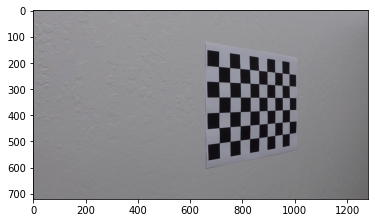

In [2]:
img = mpimg.imread('./camera_cal/calibration8.jpg')
plt.imshow(img)

(720, 1280, 3)


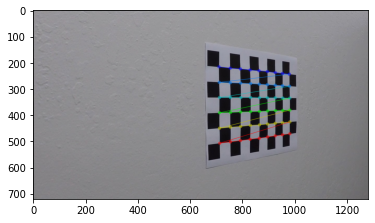

In [3]:
#chessborad pattern is 9*6
nx = 9
ny =6
# convert to grayscale 
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
# finding corners with cv2.findchessboardcorner
ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
if ret == True:
    cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
    plt.imshow(img)
print(img.shape)

## Calibrate Camera

In [4]:
images = glob.glob('./camera_cal/calibration*.jpg')
## create obj point grids
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
img_shape = cv2.imread('./camera_cal/calibration8.jpg').shape

## 3D real world points
obj_points = []
## 2D image points
img_points = []
for idx, name in enumerate(images):
    img = mpimg.imread(name)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    if ret == True:
        cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
        obj_points.append(objp)
        img_points.append(corners)
_, mtx, dist, _, _ = cv2.calibrateCamera(obj_points, img_points, 
                                         img_shape[:2],None,None)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )       

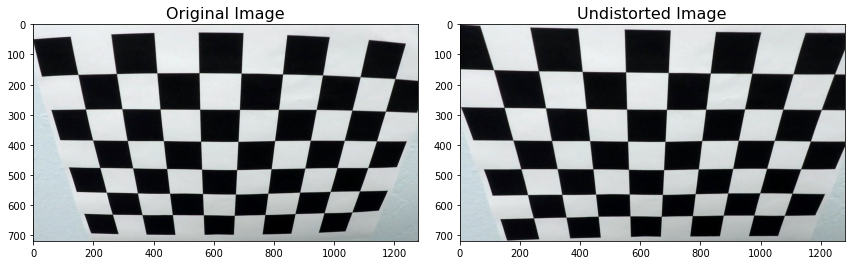

In [5]:
## Test calibration result
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

test_img = cv2.imread('./camera_cal/calibration2.jpg')
undist = cv2.undistort(test_img, mtx, dist, None, mtx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=16)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=16)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("./output_images/distortion_correction.jpg")

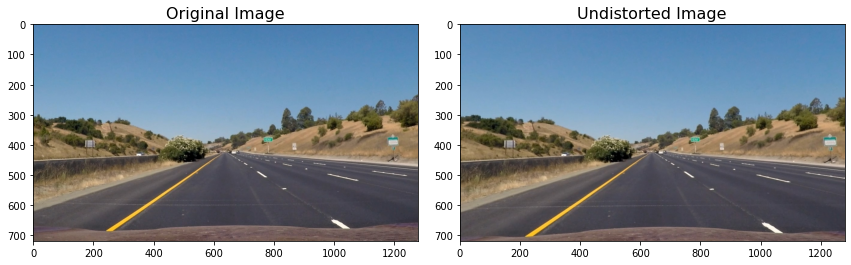

In [6]:
test_img = mpimg.imread('./test_images/straight_lines1.jpg')
undist = cv2.undistort(test_img, mtx, dist, None, mtx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=16)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=16)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# plt.show()
plt.savefig("./output_images/distortion_correction_road.jpg")

# Perspective Transform

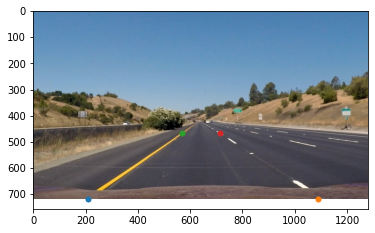

In [7]:
## Use test image with straight lines to test perspective transform results
# %matplotlib inline
# %matplotlib qt
test_img = mpimg.imread('./test_images/straight_lines1.jpg')
plt.imshow(test_img)
plt.plot(210,720,marker=".", markersize=10)
plt.plot(1090,720,marker=".", markersize=10)
plt.plot(570,467,marker=".", markersize=10)
plt.plot(714,467,marker=".", markersize=10)
# plt.show()
plt.savefig("./output_images/select_region.jpg")

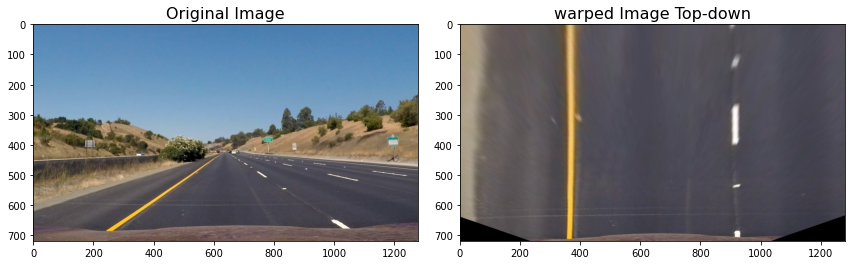

In [8]:
def get_pt(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[200,720],
                    [1100,720],
                    [570,467],
                    [714,467]])
    dst = np.float32([[360,720],
                  [920,720],
                  [360,0],
                  [920,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size,  flags=cv2.INTER_LINEAR)
   
    return warped, M, Minv

def warped_pt(img, mtx, dist, M):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    img_size = (img.shape[1], img.shape[0])
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size,  flags=cv2.INTER_LINEAR)
    return warped

def unwarp_img(warped, Minv):
    img_size = (warped.shape[1], warped.shape[0])
    # Warp the image using OpenCV warpPerspective()
    unwarped = cv2.warpPerspective(warped, Minv, img_size)
    return unwarped

warped_test, M, Minv = get_pt(test_img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=16)
ax2.imshow(warped_test)
ax2.set_title('warped Image Top-down', fontsize=16)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# plt.show()
plt.savefig("./output_images/pt_road.jpg")

# Color Thresholding

In [9]:
## Threshold 
def abs_sobel_thresh(grad_sobel, thresh = (0,255)):

    abs_sobel = np.absolute(grad_sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_sobel_thresh_(sobelx, sobely, mag_thresh=(0, 255)):
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output    

def dir_sobel_thresh(sobelx, sobely, thresh=(0, np.pi/2)):
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

def hls_select(s_channel, thresh=(0, 255)):
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary_output

def threshold_binary(img, sobel_kernel = 3, **kwargs):
    # load thresholds
    s_thresh = kwargs['s_thresh']
    x_thresh = kwargs['x_thresh']
    y_thresh = kwargs['y_thresh']
    mag_thresh = kwargs['mag_thresh']
    dir_thresh = kwargs['dir_thresh']
    # convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # l is essentially grayscale
    l_channel = hls[:,:,1]
    # s for color saturation thresholding
    s_channel = hls[:,:,2]
    
    # apply gradient thhreshold functions
    dx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    dy = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    binary_dx = abs_sobel_thresh(dx, x_thresh)
    binary_dy = abs_sobel_thresh(dy, y_thresh)
    binary_mag = mag_sobel_thresh_(dx, dy, mag_thresh)
    binary_dir = dir_sobel_thresh(dx, dy, mag_thresh)
    
    # combined gradient thresholding
    combined = np.zeros_like(binary_dir)
    binary_idx = (((binary_dx == 1) & (binary_dy == 1)) |
                  ((binary_mag == 1) & (binary_dir == 1)))
    combined[binary_idx] = 1
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    binary = np.zeros_like(s_binary)
    binary[((combined == 1) | (s_binary == 1))] = 1
    
    return binary




In [10]:
THRESHOLDS = {"s_thresh": (170,255),
             "x_thresh": (20,100),
             "y_thresh": (20,100),
             "mag_thresh": (30, 100),
             "dir_thresh": (0.7, 1.3)}
KSIZE = 3

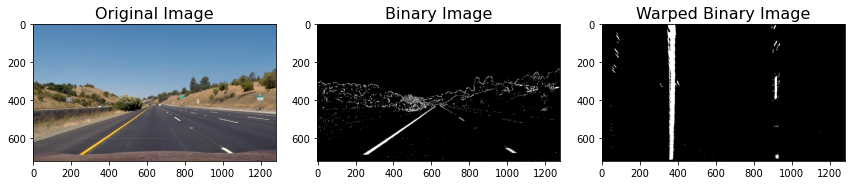

In [11]:
binary = threshold_binary(test_img, KSIZE, **THRESHOLDS)

warped_img = warped_pt(binary,mtx, dist, M)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=16)
ax2.imshow(binary, cmap = 'gray')
ax2.set_title('Binary Image', fontsize=16)
ax3.imshow(warped_img, cmap = 'gray')
ax3.set_title('Warped Binary Image', fontsize=16)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

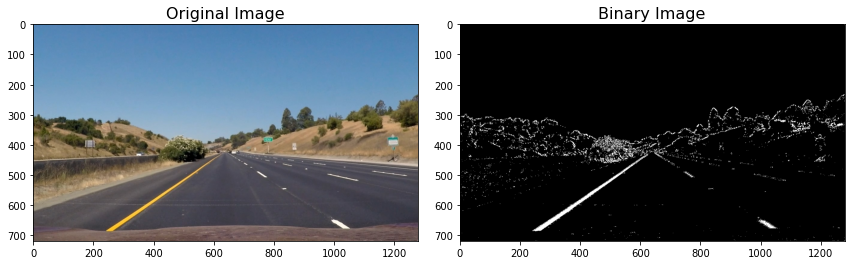

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=16)
ax2.imshow(binary, cmap = 'gray')
ax2.set_title('Binary Image', fontsize=16)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# plt.show()
plt.savefig("./output_images/binary_road.jpg")

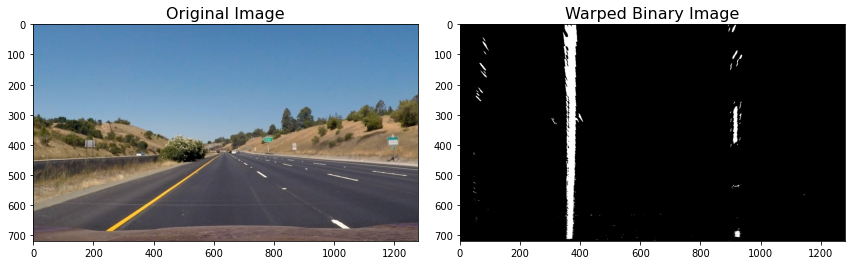

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=16)
ax2.imshow(warped_img, cmap = 'gray')
ax2.set_title('Warped Binary Image', fontsize=16)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# plt.show()
plt.savefig("./output_images/binary_road_pt.jpg")

## Lane Finding

In [13]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    # scale to 255 for plotting
    if np.max(binary_warped) == 1:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, out_img

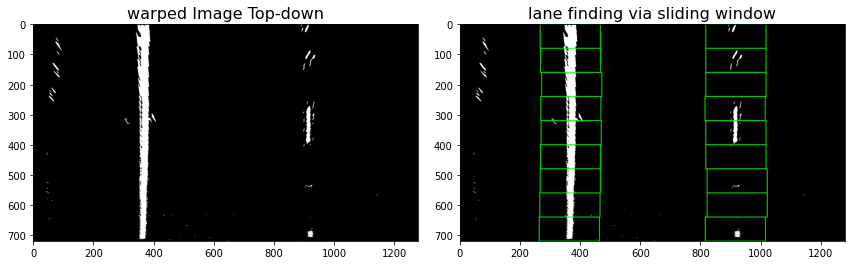

In [14]:
leftx, lefty, rightx, righty, window_img = find_lane_pixels(warped_img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()
ax1.imshow(warped_img, cmap ='gray')
ax1.set_title('warped Image Top-down', fontsize=16)
ax2.imshow(window_img)
ax2.set_title('lane finding via sliding window', fontsize=16)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


In [15]:
### given points fit polynomial lines
def fit_polynomial(leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    return left_fit, right_fit

def poly_lines(left_fit, right_fit, warped_img):
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    return left_fitx, right_fitx, ploty
# def fit_poly(left_x,left_y,right_x,right_y, warped_img):
#     left_fit = np.polyfit(lefty,leftx,2)
#     right_fit = np.polyfit(righty,rightx,2)
def shade_road(warped_img,left_fitx, right_fitx, ploty):
    width, height =warped_img.shape[0:2]
    canvas = np.zeros((width, height,3))
    left_points = np.stack((left_fitx,ploty), axis = 1)
    right_points = np.stack((right_fitx,ploty), axis = 1)
    right_points = np.flip(right_points, axis = 0)
    lanePoints = np.vstack((left_points,right_points)).astype(int)

    cv2.fillPoly(canvas,[lanePoints],(0,255, 0))
#     plt.plot(left_fitx+12, ploty, color='yellow', linewidth = 8)
#     plt.plot(right_fitx-12, ploty, color='yellow', linewidth = 8)
    for point in lanePoints:
        canvas[point[1], point[0]-6:point[0]+6,:] = [255,0,0]
    return canvas

In [16]:
left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
left_fitx, right_fitx, ploty = poly_lines(left_fit, right_fit, warped_img)
canvas = shade_road(warped_img, left_fitx, right_fitx, ploty)
# plt.imshow(canvas)
np.max(canvas)

255.0

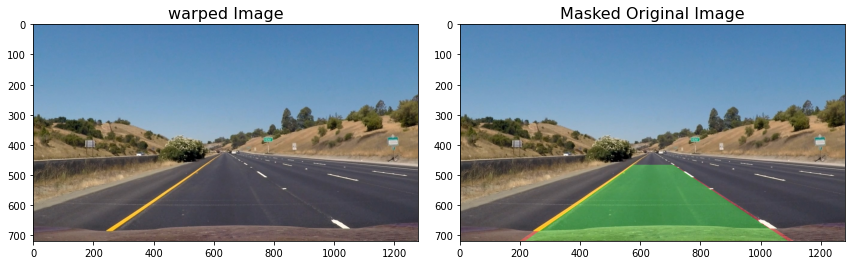

In [17]:
unwarped_test = unwarp_img(canvas, Minv)
masked_img = cv2.addWeighted(test_img,1,unwarped_test,0.3,0,dtype=cv2.CV_8UC1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()
ax1.imshow(test_img)
ax1.set_title('warped Image', fontsize=16)
ax2.imshow(masked_img)
ax2.set_title('Masked Original Image', fontsize=16)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [18]:
YSCALE = 30 / 720
XSCALE = 3.7 / 700
HEIGHT = 720
WIDTH = 1280

In [19]:
def scaled_fit(lane_fit):
    res = [0, 0, 0]
    try:
        res[0] = XSCALE/(YSCALE**2)*lane_fit[0]
        res[1] = XSCALE/YSCALE*lane_fit[1]
        res[2] = lane_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('Failed to convert to real world scale')
def get_curvature(left_fit, right_fit):
    
    left_curverad = (1 + (2*(HEIGHT -1 )*left_fit[0] + left_fit[1])**2)**1.5/(2*np.absolute(left_fit[0]))
    right_curverad = (1 + (2*(HEIGHT -1 )*right_fit[0] + right_fit[1])**2)**1.5/(2*np.absolute(right_fit[0]))
    return (left_curverad+ right_curverad) /2
def get_center(left_fitx, right_fitx):
    center = WIDTH//2
    dist = (left_fitx[-1] + right_fitx[-1])/2 - center
    if dist >= 0:
        direct = 'Right'
    else:
        direct = 'Left'
    return dist*XSCALE, direct

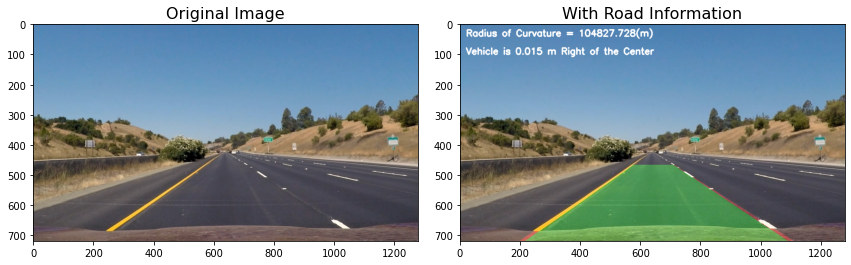

In [25]:
center,direct = get_center(left_fitx,right_fitx)
curvature = get_curvature(left_fit,right_fit)

font = cv2.FONT_HERSHEY_SIMPLEX
fontColor = (255,255,255)

cv2.putText(masked_img,
            "Radius of Curvature = {:.3f}(m)".format(curvature),
            (20,40),font, 1, fontColor,3)
cv2.putText(masked_img,
            "Vehicle is {:.3f} m {} of the Center".format(center, direct),
            (20,100),font, 1, fontColor,3)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=16)
ax2.imshow(masked_img)
ax2.set_title('With Road Information', fontsize=16)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# plt.show()
plt.savefig("./output_images/pipline_demo.jpg")

In [21]:
def fit_poly(left_x,left_y,right_x,right_y, warped_img):
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    return left_fitx, right_fitx, ploty
def search_around_poly(binary_warped,left_fit,right_fit):
    margin = 100
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    #extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    